# Téléchargement des données ERA5

Source : https://cds.climate.copernicus.eu/cdsapp#!/dataset/reanalysis-era5-single-levels-monthly-means?tab=form

Merci beaucoup à https://github.com/lrntct/pxr/blob/master/dl_era5.py

```
$ cat ~/.cdsapirc
url: https://cds.climate.copernicus.eu/api/v2
key: <UID>:<API key>
verify: 0
```

France Bounding Box : -4.943848,41.967659,8.503418,51.110420


cartopy :
sudo apt -y install libgeos-dev

In [1]:
!source ../.env

In [ ]:
import os
import shutil
import multiprocessing as mp
import urllib3
import zipfile
import xarray as xr
import zarr
import cdsapi
import humanize
import requests

In [9]:
# Disable warning
urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)


DATA_DIR = "../data/meteo/ERA5/monthly_dl"

if not os.path.exists(DATA_DIR):
    raise FileNotFoundError(f"{DATA_DIR} does not exist")

"""
c.retrieve(
    'reanalysis-era5-single-levels-monthly-means',
    {
        'format': 'netcdf',
        'product_type': 'monthly_averaged_reanalysis',
        'variable': [
            '2m_temperature', 'total_precipitation',
        ],
        'year': '2024',
        'month': [
            '01', '02', '03',
            '04', '05', '06',
            '07', '08', '09',
            '10', '11', '12',
        ],
        'time': '00:00',
    },
    'download.nc')
"""


FORMAT = "netcdf"
# Daily
# PRODUCT = 'reanalysis-era5-single-levels'
# TYPE = 'reanalysis'
# TYPE = 'ensemble_members'
TIME = [f"{i}:00".zfill(5) for i in range(24)]

# Monthly
PRODUCT = "reanalysis-era5-single-levels-monthly-means"
VARIABLE = ["total_precipitation", "2m_temperature"]

TYPE = "monthly_averaged_reanalysis"

MONTH = [str(i + 1).zfill(2) for i in range(2)]
DAY = [str(i + 1).zfill(2) for i in range(31)]
TIME = "00:00"
START_YEAR = 2024
END_YEAR = 2024

DTYPE = "float32"
CHUNKS = {"time": -1, "latitude": 16, "longitude": 16}
GEN_FLOAT_ENCODING = {"dtype": DTYPE, "compressor": zarr.Blosc(cname="lz4", clevel=9)}
ENCODING = {"temperature": GEN_FLOAT_ENCODING}


def get_url(year, month):
    cds_client = cdsapi.Client(
        url=os.environ.get("CDS_API_URL"), key=os.environ.get("CDS_API_KEY")
    )
    query = {
        "variable": VARIABLE,
        "product_type": TYPE,
        "year": year,
        "month": month,
        # "day": DAY,
        "time": TIME,
        "format": FORMAT,
        # Métropole
        # 'area': [
        # 52, -6, 40,
        # 10,
        # ],
    }
    cds_r = cds_client.retrieve(PRODUCT, query)
    url = cds_r.location
    file_size = int(cds_r.content_length)
    return url, file_size


def dl_cdsapi(year_month):
    """Download one month of data as a single file"""
    # saved filename on disk
    filename = f"{year_month[0]}-{year_month[1]}_global.{FORMAT}"
    # Make sure that the TCP request returns the right file size:
    size_diff = 1
    while size_diff != 0:
        url, file_size = get_url(str(year_month[0]), year_month[1])
        print(url)
        resp = requests.get(url, stream=True, timeout=(5, 5))
        total_length = int(resp.headers.get("content-length"))
        size_diff = file_size - total_length

    # Retry until the file is complete
    disk_url = os.path.join(DATA_DIR, filename)
    print(f"Writing to {disk_url}")
    dl_size = 0
    while dl_size < file_size:
        with open(disk_url, "ab") as f:
            dl_size = f.tell()
            print(
                "{}, full size:{} DL starting at {}".format(
                    filename,
                    humanize.naturalsize(file_size),
                    humanize.naturalsize(dl_size),
                )
            )
            # If timeout, re-initiate the download
            headers = {"Range": f"bytes={dl_size}-"}
            try:
                resp = requests.get(url, stream=True, timeout=(5, 5), headers=headers)
                shutil.copyfileobj(resp.raw, f)
            except (
                requests.exceptions.ReadTimeout,
                urllib3.exceptions.ReadTimeoutError,
            ):
                continue
            dl_size = f.tell()

In [10]:
# url, file_size = get_url(2024, "01")
# print(f"URL: {url}, File size: {file_size} bytes")

In [49]:
pool = mp.Pool(1)
year_month = [("2020", "01")]
dl_cdsapi(year_month[0])
# pool.map(dl_cdsapi, year_month)

2025-02-12 13:08:42,203 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-02-12 13:08:42,204 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-02-12 13:08:42,435 INFO Request ID is e6d2b2f0-dbd8-42eb-894f-f94a6a0f1ab9
2025-02-12 13:08:42,503 INFO status has been updated to accepted
2025-02-12 13:08:51,068 INFO status has been updated to running
2025-02-12 13:09:03,854 WARNING Structural differences in grib fields detected when opening in xarray. Opening the grib file safely, however this may result in files with non-intuitive filenames.
2025-02-12 13:09:03,855 INFO status has been updated to successful


https://object-store.os-api.cci2.ecmwf.int:443/cci2-prod-cache-1/2025-02-12/96881257b3e6014ea23e2d8257ac5940.zip
Writing to ../data/meteo/ERA5/monthly_dl/2020-01_global.netcdf
2020-01_global.netcdf, full size:2.8 MB DL starting at 0 Bytes


In [ ]:
disk_url = "../data/meteo/ERA5/monthly_dl/2024-02_global.netcdf"


def handle_new_file_format(disk_url, temp_dir):
    if zipfile.is_zipfile(disk_url):
        print("C'est le nouveau format. Extracting zip file...")
    else:
        return
    with zipfile.ZipFile(disk_url, "r") as zip_ref:
        shutil.rmtree(temp_dir, ignore_errors=True)
        os.makedirs(temp_dir, exist_ok=True)
        shutil.copy(disk_url, temp_dir)
        zip_ref.extractall(temp_dir)
    files = os.listdir(temp_dir)
    tp_dataset = None
    t2m_dataset = None
    for f in files:
        if f.endswith(".nc"):
            file = os.path.join(temp_dir, f)
            print(file)
            nc_dataset = xr.open_dataset(file, engine="netcdf4")
            if "tp" in nc_dataset.variables:
                tp_dataset = nc_dataset
            elif "t2m" in nc_dataset.variables:
                t2m_dataset = nc_dataset
    if tp_dataset and t2m_dataset:
        merged_dataset = xr.merge([tp_dataset, t2m_dataset])
        # Overwrite the original file
        merged_dataset.to_netcdf(disk_url)
    else:
        raise ValueError(
            "Both tp and t2m variables are not found in the new format files."
        )
    shutil.rmtree(temp_dir, ignore_errors=True)


handle_new_file_format(disk_url)
nc_dataset = xr.open_dataset(disk_url, engine="netcdf4")

In [45]:
if "tp" in nc_dataset.variables:
    print("t2m is present in the dataset variables.")
else:
    print("t2m is not present in the dataset variables.")

t2m is not present in the dataset variables.


In [36]:
nc_dataset["t2m"].values[0][50][50]

np.float32(269.01184)

/home/ben/LEXIMPACT/datacirco-prepare-data/.venv/lib/python3.11/site-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_physical/ne_110m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


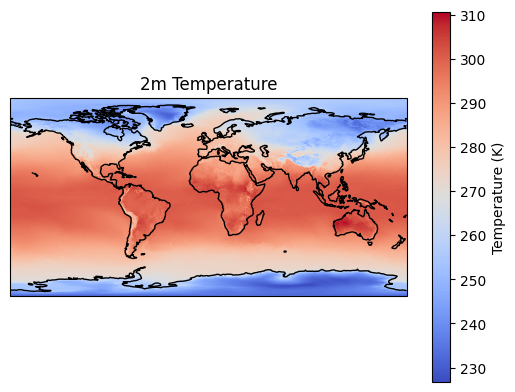

In [37]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

# Extract the data
t2m = nc_dataset["t2m"].values[0]

# Create a figure and axis with a map projection
fig, ax = plt.subplots(subplot_kw={"projection": ccrs.PlateCarree()})

# Plot the data
c = ax.pcolormesh(
    nc_dataset["longitude"],
    nc_dataset["latitude"],
    t2m,
    transform=ccrs.PlateCarree(),
    cmap="coolwarm",
)

# Add coastlines for reference
ax.coastlines()

# Add a colorbar
fig.colorbar(c, ax=ax, orientation="vertical", label="Temperature (K)")

# Set the title
ax.set_title("2m Temperature")

# Show the plot
plt.show()

In [23]:
nc_dataset

<xarray.Dataset> Size: 4MB
Dimensions:     (valid_time: 1, latitude: 721, longitude: 1440)
Coordinates:
    number      int64 8B ...
  * valid_time  (valid_time) datetime64[ns] 8B 2024-02-01T06:00:00
  * latitude    (latitude) float64 6kB 90.0 89.75 89.5 ... -89.5 -89.75 -90.0
  * longitude   (longitude) float64 12kB 0.0 0.25 0.5 0.75 ... 359.2 359.5 359.8
    expver      <U4 16B ...
Data variables:
    tp          (valid_time, latitude, longitude) float32 4MB ...
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts

Les températures sont en Kelvin !